In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [4]:
zip_files = ['test1', 'train']

for zip_file in zip_files:
    #The with statement ensures that the ZIP file is properly closed after the operations inside the block are completed, 
    #even if an error occurs.
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:#opens the specified ZIP file in read mode ("r").
        z.extractall(".")#This line extracts all the contents of the currently opened ZIP file (z) to the current directory (".").
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [5]:
TRAIN_DIR_PATH = './train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [6]:
file_names[0]

'dog.9521.jpg'

In [7]:
def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)

In [8]:
df.head()

,filename,label
0,dog.9521.jpg,dog
1,dog.7575.jpg,dog
2,cat.6343.jpg,cat
3,cat.6868.jpg,cat
4,dog.965.jpg,dog


data set label distribution:
 label
cat    12500
dog    12500
Name: count, dtype: int64


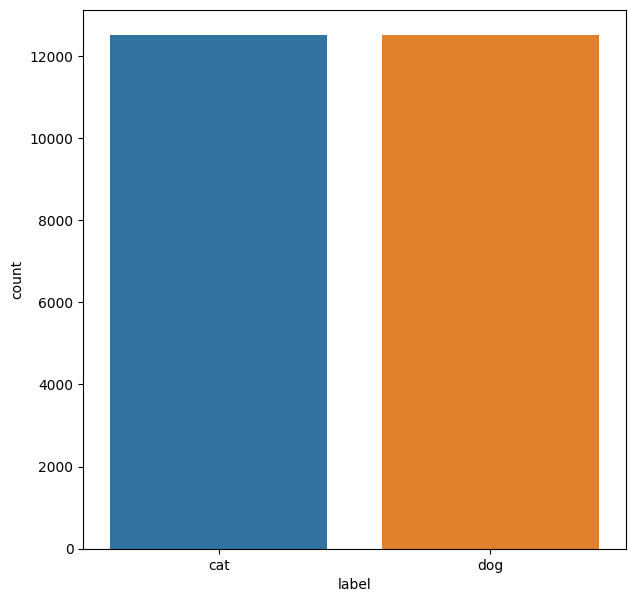

In [7]:
print('data set label distribution:\n',df['label'].value_counts())

plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.show()

In [9]:
cat = [file for file in file_names if file[:3]=='cat']
dog = [file for file in file_names if file[:3]=='dog']

In [10]:
dog[:10]

['dog.9521.jpg',
 'dog.7575.jpg',
 'dog.965.jpg',
 'dog.6746.jpg',
 'dog.8600.jpg',
 'dog.7693.jpg',
 'dog.11837.jpg',
 'dog.6683.jpg',
 'dog.1337.jpg',
 'dog.9236.jpg']

In [11]:
# Randomly print a CAT Image
im = img.imread('./train/cat.11789.jpg')
im

array([[[148, 153, 149],
        [148, 153, 149],
        [148, 153, 149],
        ...,
        [155, 157, 152],
        [155, 157, 152],
        [155, 157, 152]],

       [[148, 153, 149],
        [148, 153, 149],
        [148, 153, 149],
        ...,
        [155, 157, 152],
        [155, 157, 152],
        [155, 157, 152]],

       [[148, 153, 149],
        [148, 153, 149],
        [148, 153, 149],
        ...,
        [155, 157, 152],
        [155, 157, 152],
        [155, 157, 152]],

       ...,

       [[138, 140, 135],
        [ 95,  97,  92],
        [141, 143, 138],
        ...,
        [133, 123, 121],
        [127, 119, 116],
        [127, 119, 116]],

       [[112, 114, 109],
        [ 80,  82,  77],
        [117, 119, 114],
        ...,
        [134, 124, 122],
        [130, 122, 119],
        [132, 124, 121]],

       [[ 52,  54,  49],
        [ 28,  30,  25],
        [ 56,  58,  53],
        ...,
        [133, 123, 121],
        [138, 130, 127],
        [149, 141, 138]]

(500, 240, 3)


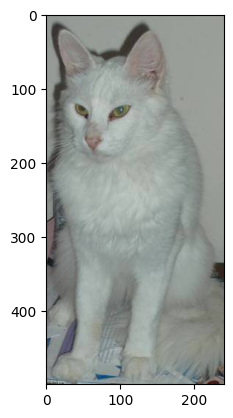

In [12]:
print(im.shape)
plt.imshow(im)
plt.show()

(500, 388, 3)


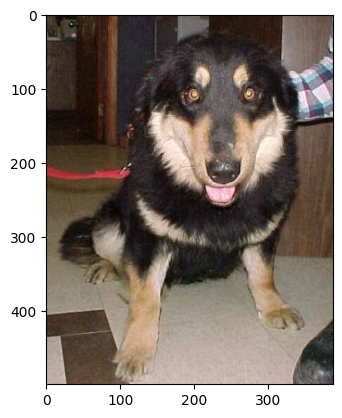

In [13]:
# Randomly print a CAT Image
im = img.imread('./train/dog.11789.jpg')
print(im.shape)
plt.imshow(im)
plt.show()

(413, 500, 3)
(291, 350, 3)
(499, 479, 3)
(374, 500, 3)


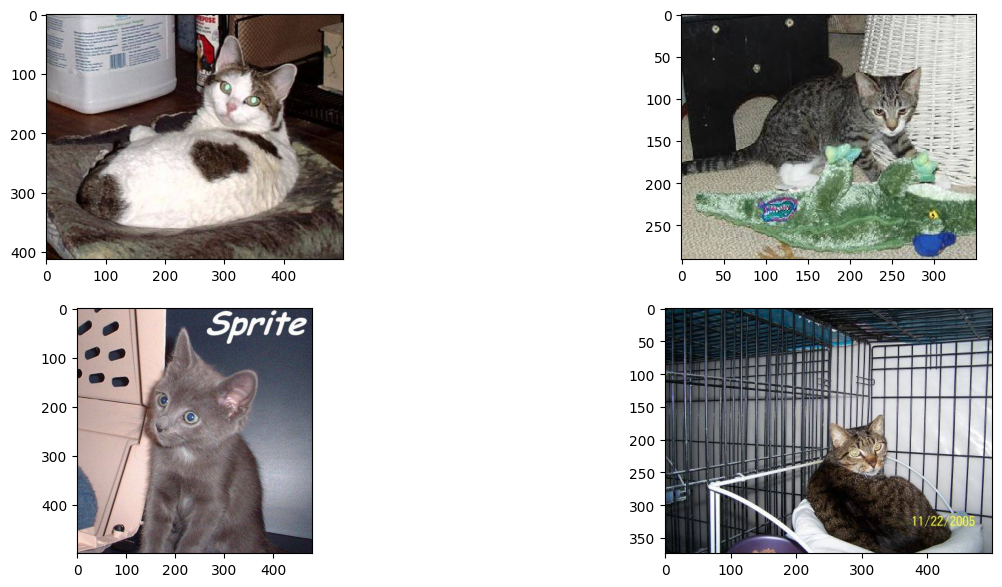

In [12]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat),4), start=1):
    im = img.imread('./train/'+cat[c])
    print(im.shape)
    plt.subplot(2,2,i)
    plt.imshow(im)
plt.show()

(319, 240, 3)
(375, 499, 3)
(392, 366, 3)
(299, 455, 3)


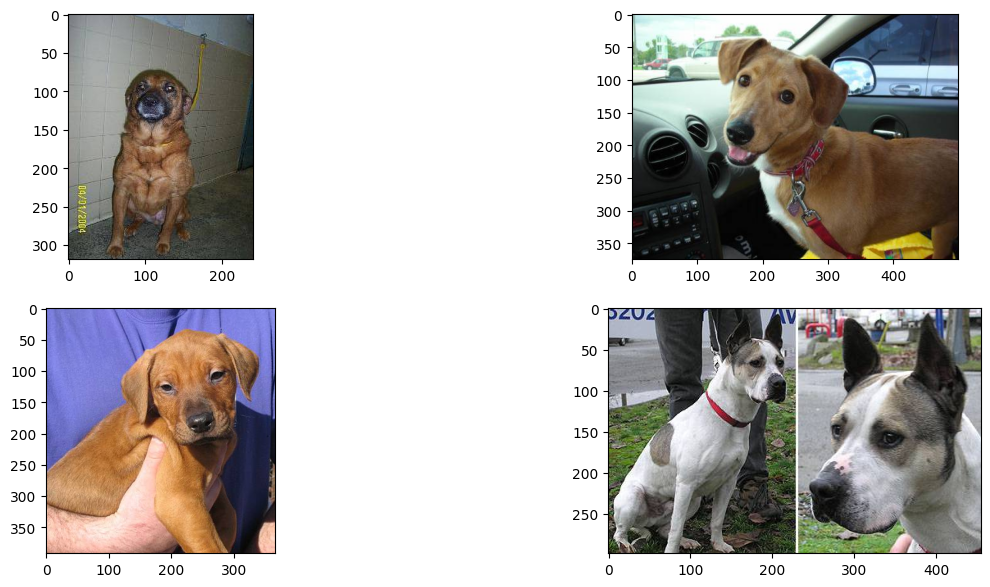

In [13]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(dog),4), start=1):
    im = img.imread('./train/'+dog[c])
    plt.subplot(2,2,i)
    print(im.shape)
    plt.imshow(im)
plt.show()

## Transfer learning approaches

you can explore all available models from here [https://keras.io/api/applications/](http://https://keras.io/api/applications/)

#### Using a pretrained network as a classifier

In [14]:
image_name = "/kaggle/working/train/cat.11789.jpg"
img = load_img(image_name)

In [15]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

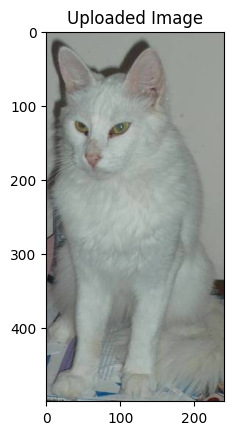

In [16]:
plt.imshow(img)
plt.title("Uploaded Image")
plt.show();

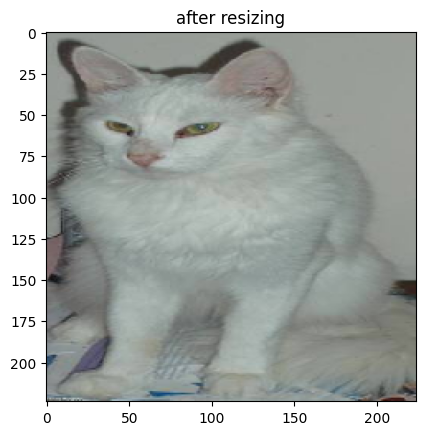

In [17]:
img = load_img(image_name, target_size=(224, 224))
plt.imshow(img)
plt.title("after resizing")
plt.show();

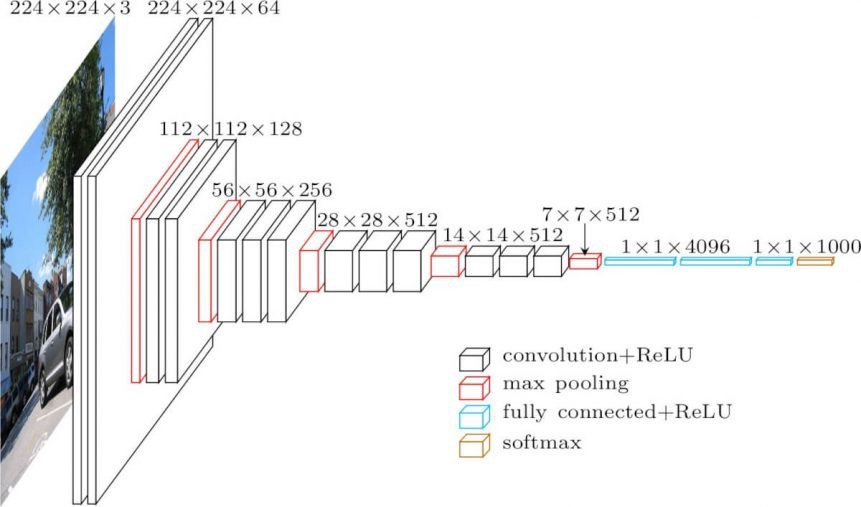

In [18]:
full_model = VGG16(weights = "imagenet",
                   include_top=True,
                   input_shape = (224,224, 3))
full_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
"""# weights="imagenet": This specifies that the model should be loaded with pre-trained weights from the ImageNet dataset. 
    The ImageNet dataset is a large visual database used to train models for various image classification tasks.
   # include_top=True: This indicates that the fully connected layers at the top of the network (used for classification) 
   should be included. Since the model was trained on ImageNet, it has 1000 output classes corresponding to different object categories.
   input_shape=(224, 224, 3): This specifies the shape of the input images expected by the model. The images should be 224x224 pixels with 3 color channels (RGB)."""
full_model = VGG16(weights = "imagenet", include_top=True, input_shape =(224,224, 3))
image = img_to_array(img)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
"""
This function from Keras preprocesses the image for the VGG16 model. 
The preprocessing involves scaling pixel values and possibly other normalization steps 
that match the preprocessing used during the original training of the VGG16 model."""
image = preprocess_input(image)

In [20]:
yhat = full_model.predict(image)

I0000 00:00:1725256847.589068     121 service.cc:145] XLA service 0x7e740400a1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725256847.589120     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1725256849.608927     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [21]:
yhat.shape

(1, 1000)

In [22]:
yhat[:,:10]

array([[3.8635795e-07, 1.4854961e-06, 4.5665392e-06, 6.1465385e-06,
        3.3487842e-05, 5.8782520e-05, 2.0425485e-05, 3.5783200e-06,
        8.0113052e-05, 6.9408537e-07]], dtype=float32)

In [23]:
""", it returns the top 5 predictions, but you can specify a different number by passing 
a top argument,like decode_predictions(yhat, top=3) for the top 3 predictions."""
label = decode_predictions(yhat)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
"""It's typically a list of tuples, where each tuple contains:
The ImageNet class ID.
The human-readable class name.
The confidence score (probability) for that class"""
label

[[('n02127052', 'lynx', 0.5883497),
  ('n02123394', 'Persian_cat', 0.17385481),
  ('n03958227', 'plastic_bag', 0.03632713),
  ('n02124075', 'Egyptian_cat', 0.028175307),
  ('n02123597', 'Siamese_cat', 0.01713292)]]

In [18]:
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

lynx (58.83%)


#### Using a pretrained network as a feature extractor

In [26]:
features_extractor = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
features_extractor.summary()#note the number of trainable parameters

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
for layer in features_extractor.layers:
    layer.trainable = False
features_extractor.summary()#note the number of non trainable parameters

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
last_layer = features_extractor.get_layer('block5_pool')
last_output = last_layer.output
x = Flatten()(last_output)
x = Dense(2, activation='softmax', name='softmax')(x)
new_model = Model(inputs=features_extractor.input, outputs=x)
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Feature selector trainer

In [29]:
train_set, valid_set = train_test_split(df, test_size=0.2,random_state=seed)

In [30]:
train_set.shape, valid_set.shape


((20000, 2), (5000, 2))

In [31]:
train_set

,filename,label
10263,dog.4751.jpg,dog
18409,cat.12411.jpg,cat
13047,cat.3145.jpg,cat
21371,dog.3260.jpg,dog
16392,cat.9581.jpg,cat
...,...,...
13123,dog.2269.jpg,dog
19648,cat.3183.jpg,cat
9845,dog.3035.jpg,dog
10799,dog.4670.jpg,dog


train set distribution:
 label
dog    10022
cat     9978
Name: count, dtype: int64

valid set distribution:
 label
cat    2522
dog    2478
Name: count, dtype: int64



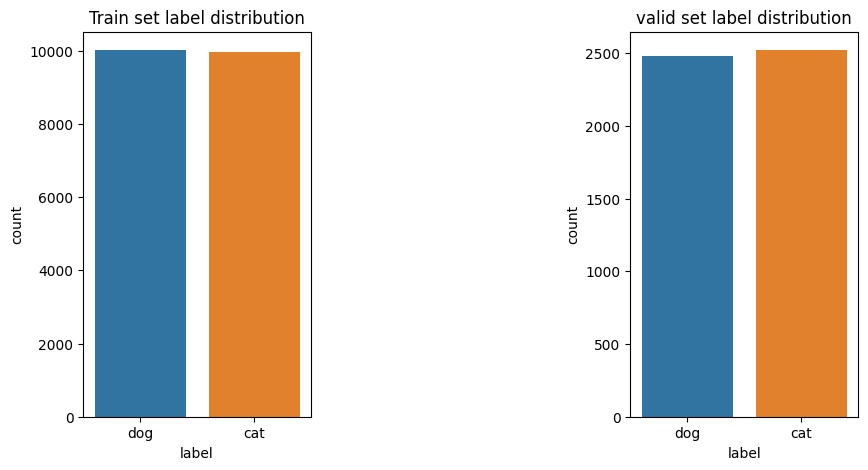

In [32]:
print('train set distribution:\n',train_set['label'].value_counts())
print('\nvalid set distribution:\n',valid_set['label'].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.countplot(x=train_set['label'], order=['dog','cat'])
plt.title('Train set label distribution')

plt.subplot(1,3,3)
sns.countplot(x=valid_set['label'], order=['dog','cat'])
plt.title('valid set label distribution')
plt.show()

In [33]:
WIDTH, HEIGHT = 224, 224
batch_size = 32

In [34]:
train_datagenerator = ImageDataGenerator(rotation_range=15,#rotation of the image within a range of 0 to 15 degrees.
                                  rescale=1./255, #This rescales the pixel values of the image by dividing them by 255.
                                  shear_range=0.1,#shear transformation, which is like stretching the image along the x or y axis.
                                                 #A shear range of 0.1 applies a shearing effect by 10% along the specified axis.
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

training_data = train_datagenerator.flow_from_dataframe(dataframe=train_set, 
                                                        directory='./train',
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [35]:
training_data.class_indices

{'cat': 0, 'dog': 1}

In [36]:
training_data.filenames[:10]

['dog.4751.jpg',
 'cat.12411.jpg',
 'cat.3145.jpg',
 'dog.3260.jpg',
 'cat.9581.jpg',
 'cat.9796.jpg',
 'cat.3206.jpg',
 'dog.1182.jpg',
 'dog.7827.jpg',
 'dog.3397.jpg']

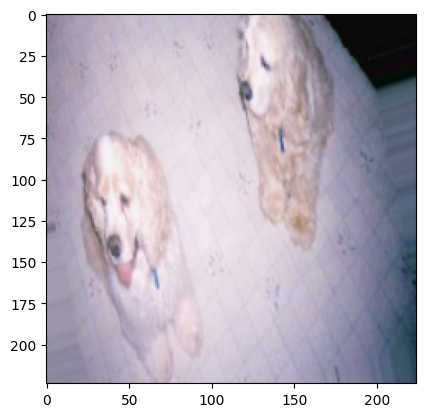

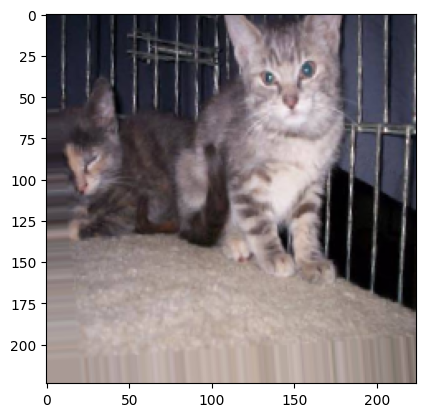

In [37]:
for i in range(len(training_data.filenames)):
    image, label = next(training_data)

    # display the image from the iterator
    plt.imshow(image[0])
#     print(new_dict[label[0]])
    plt.show()
    if i >0:
        break

In [38]:
valid_datagenerator = ImageDataGenerator(rescale=1./255)
validation_data = valid_datagenerator.flow_from_dataframe(dataframe=valid_set,
                                                         directory='./train',
                                                         x_col='filename',
                                                         y_col='label',
                                                         target_size=(WIDTH,HEIGHT),
                                                         class_mode='categorical',
                                                         batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [40]:
earlystop_cb = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)



callbacks = [earlystop_cb, reduce_lr_cb]

In [41]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [42]:
new_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [43]:
history = new_model.fit(training_data,
                   epochs=10,
                   validation_data=validation_data,
                     validation_steps=10,#This defines the number of batches of validation data that the model will evaluate at the end of each epoch.
                     steps_per_epoch=10, #This defines the number of batches of training data to be processed before the epoch is considered finished.
                                        #If your training_data is a generator or a dataset, steps_per_epoch=10 means 
                                        #that the model will run 10 batches per epoch.
                   callbacks=callbacks)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.5060 - loss: 1.7796 - val_accuracy: 0.5000 - val_loss: 1.1866 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.5804 - loss: 0.8814 - val_accuracy: 0.5969 - val_loss: 0.8217 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.7308 - loss: 0.5610 - val_accuracy: 0.8625 - val_loss: 0.3325 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.8626 - loss: 0.3352 - val_accuracy: 0.8250 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step - accuracy: 0.7929 - loss: 0.4104 - val_accuracy: 0.8438 - val_loss: 0.3215 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.7836 - loss: 0.4601 - val_accuracy: 0.8156 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.8649 - loss: 0.3719 - val_accura

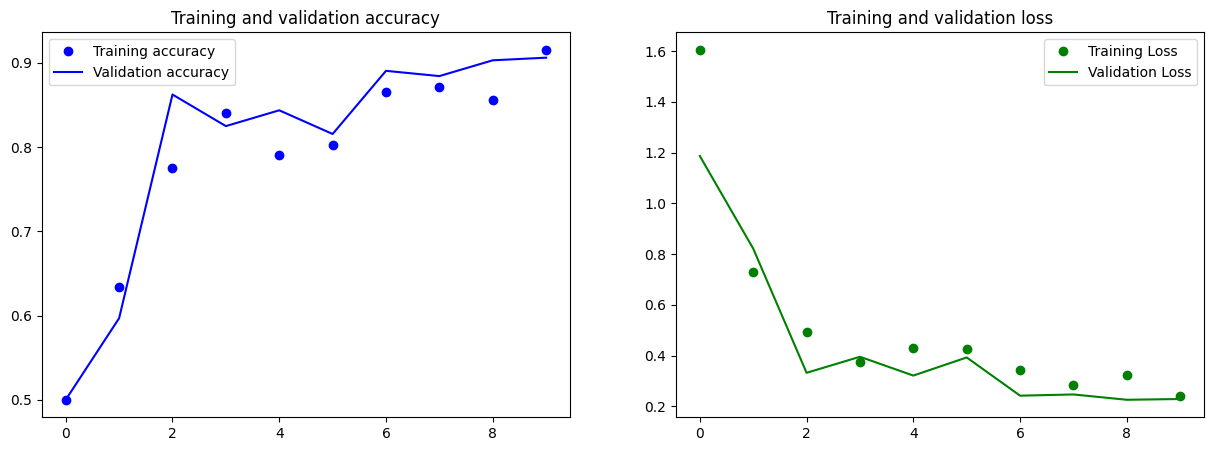

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine Tuning approach

In [45]:
fine_tune_feat_ext = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
fine_tune_feat_ext.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
last_layer = fine_tune_feat_ext.get_layer('block5_pool')
last_output = last_layer.output
x = Flatten()(last_output)
x = Dense(2, activation='softmax', name='softmax')(x)
new_model_2 = Model(inputs=fine_tune_feat_ext.input, outputs=x)
new_model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 14,764,866 (56.32 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
opt2= keras.optimizers.Adam(learning_rate=0.001)

In [48]:
new_model_2.compile(loss="categorical_crossentropy", optimizer=opt2, metrics=['accuracy'])

In [49]:
history = new_model_2.fit(training_data,
                   epochs=10,
                   validation_data=validation_data,
                     validation_steps=10,
                     steps_per_epoch=10, 
                   callbacks=callbacks)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 486ms/step - accuracy: 0.4790 - loss: 11.5838 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.5319 - loss: 0.7158 - val_accuracy: 0.5813 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.4912 - loss: 0.7616 - val_accuracy: 0.5031 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.5018 - loss: 0.6960 - val_accuracy: 0.5219 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.5519 - loss: 0.6917 - val_accuracy: 0.5125 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - accuracy: 0.5385 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.6958 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.4996 - loss: 0.6965 

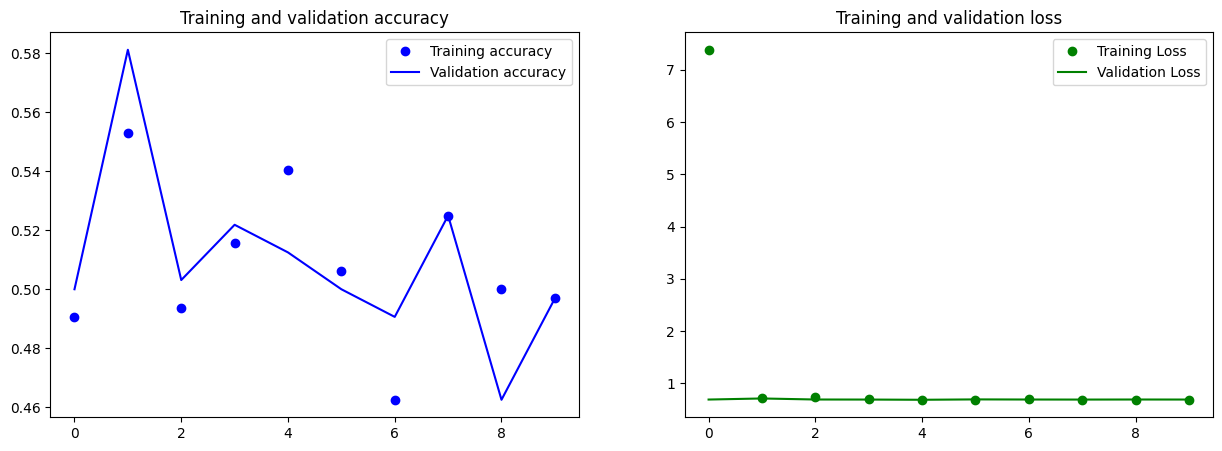

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()